<a href="https://colab.research.google.com/github/Omkaarr1/MEDICAL-IMAGE-CLASSIFICATION-FOR-DISEASE-DIAGNOSIS-USING-CONVOLUTIONAL-NEURAL-NETWORKS/blob/main/Pneumonia_Detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

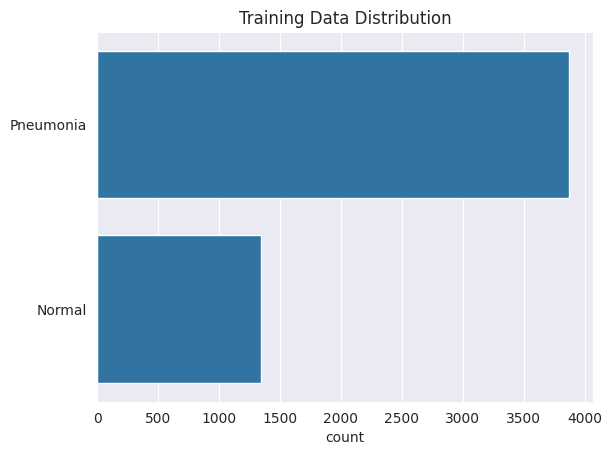

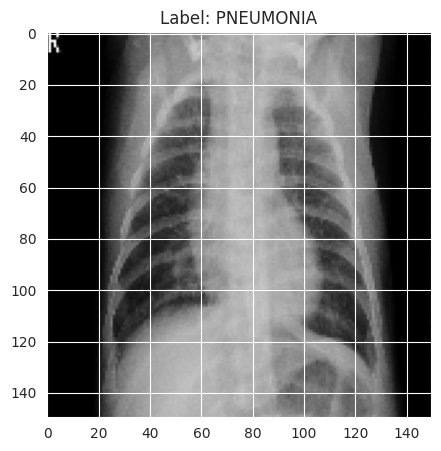

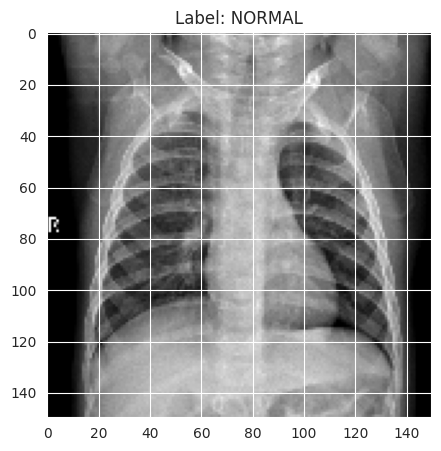

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 1s 61ms/step - loss: 0.3164 - accuracy: 0.8654
Test Loss: 0.31635749340057373
Test Accuracy: 86.53846383094788%


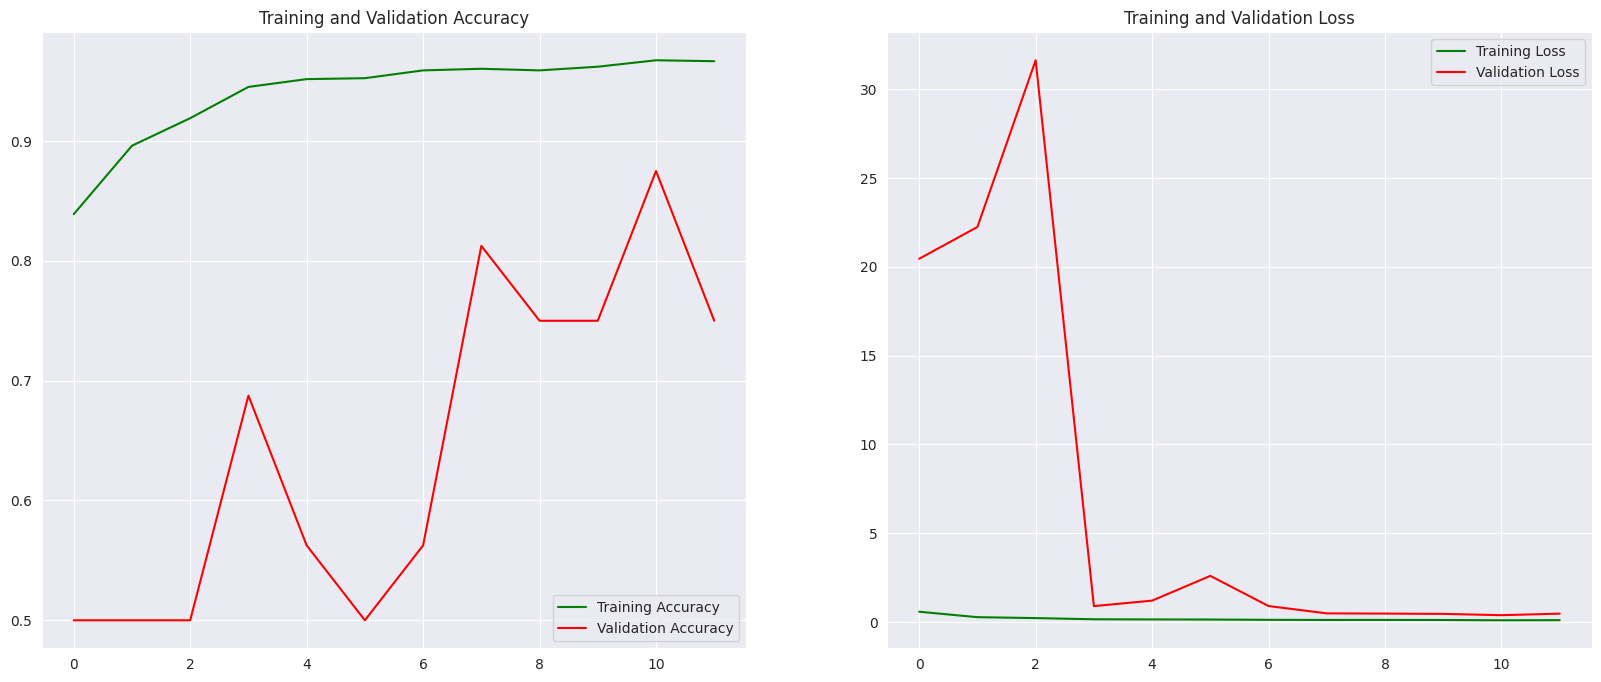

20/20 [==============================] - 1s 63ms/step
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.96      0.82      0.88       390
   Normal (Class 1)       0.76      0.95      0.84       234

           accuracy                           0.87       624
          macro avg       0.86      0.88      0.86       624
       weighted avg       0.89      0.87      0.87       624



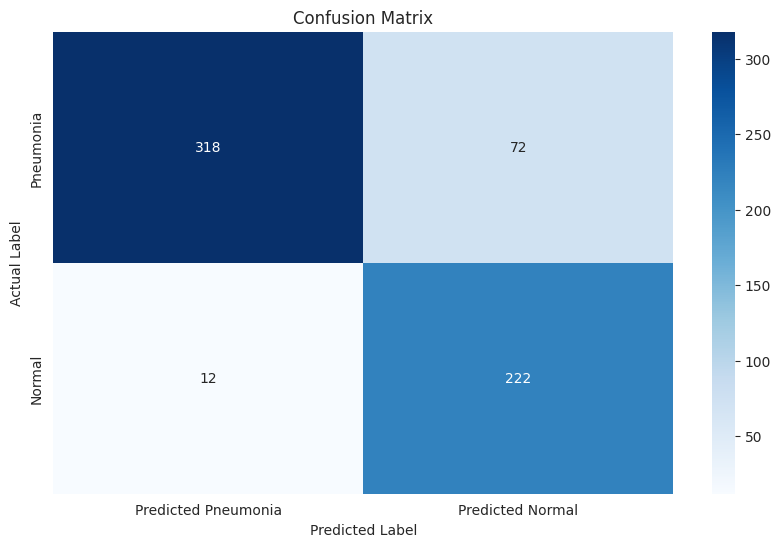

Model loaded successfully.
Error: Could not read image.


In [14]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import cv2
import imghdr
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Define labels and image size
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

# Function to load and preprocess data
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            # Check if the file is an image
            if imghdr.what(img_path):
                try:
                    img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img_arr is not None:
                        resized_arr = cv2.resize(img_arr, (img_size, img_size))
                        data.append([resized_arr, class_num])
                    else:
                        print(f"Failed to read image {img_path}")
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
            else:
                print(f"Skipped non-image file: {img_path}")
    return data

# Load the data
train_data = get_data('../input/chest-xray-pneumonia/chest_xray/train')
test_data = get_data('../input/chest-xray-pneumonia/chest_xray/test')
val_data = get_data('../input/chest-xray-pneumonia/chest_xray/val')

# Separate features and labels
def separate_features_and_labels(data):
    images = []
    labels = []
    for feature, label in data:
        images.append(feature)
        labels.append(label)
    return np.array(images), np.array(labels)

x_train, y_train = separate_features_and_labels(train_data)
x_test, y_test = separate_features_and_labels(test_data)
x_val, y_val = separate_features_and_labels(val_data)

# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0
x_val = x_val / 255.0

# Reshape the data
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_test = x_test.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)

# Data Visualization
l = ['Pneumonia' if label == 0 else 'Normal' for label in y_train]
sns.set_style('darkgrid')
sns.countplot(l)
plt.title('Training Data Distribution')
plt.show()

# Previewing the images of both classes
plt.figure(figsize=(5,5))
plt.imshow(x_train[0].reshape(img_size, img_size), cmap='gray')
plt.title('Label: ' + labels[y_train[0]])
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(x_train[-1].reshape(img_size, img_size), cmap='gray')
plt.title('Label: ' + labels[y_train[-1]])
plt.show()

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# Define the model
model = Sequential()
model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(256, (3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1,
                                            factor=0.3, min_lr=1e-6)

# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=12,
                    validation_data=(x_val, y_val), callbacks=[learning_rate_reduction])

# Save the trained model
model.save('pneumonia_model.h5')
print("Model saved as pneumonia_model.h5")

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100}%")

# Plotting Training and Validation Accuracy and Loss
epochs_range = range(12)
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], 'g-', label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], 'g-', label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

plt.show()

# Make predictions on the test set
predictions = (model.predict(x_test) > 0.5).astype("int32").reshape(-1)
print(classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=['Pneumonia', 'Normal'], columns=['Predicted Pneumonia', 'Predicted Normal'])
plt.figure(figsize=(10, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()



Model loaded successfully.
1/1 [==============================] - 0s 138ms/step
The image is classified as Pneumonia.


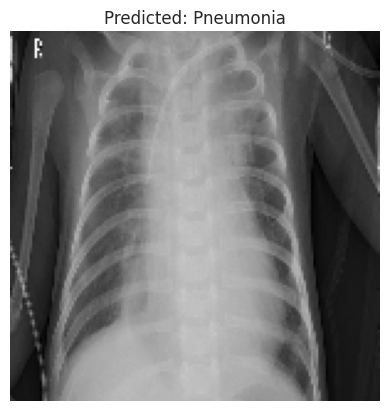

In [16]:

# Load the saved model for prediction
loaded_model = load_model('pneumonia_model.h5')
print("Model loaded successfully.")

# Function to preprocess and predict the class of an input image
def predict_image(image_path):
    img_size = 150  # The image size your model expects
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not read image.")
        return
    # Resize the image
    img_resized = cv2.resize(img, (img_size, img_size))
    # Normalize the image
    img_normalized = img_resized / 255.0
    # Reshape the image to match the input shape of the model
    img_reshaped = img_normalized.reshape(1, img_size, img_size, 1)
    # Make a prediction
    prediction = loaded_model.predict(img_reshaped)
    # Interpret the prediction
    if prediction[0][0] > 0.5:
        result = "Normal"
    else:
        result = "Pneumonia"
    print(f"The image is classified as {result}.")

    # Plot the image
    plt.imshow(img_resized, cmap='gray')
    plt.title(f"Predicted: {result}")
    plt.axis('off')
    plt.show()

# Example usage:
# Replace 'path_to_your_image.jpg' with the actual path to your image file
image_path = '1.jpeg'
predict_image(image_path)